In [45]:
%pip -q install gdown
%pip -q install catboost

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %pip -q install --upgrade pyarrow
# %pip -q install --upgrade numpy
# %pip -q install --upgrade networkx[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 46.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 12.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 12.0.0 which is incompatible.
^C


In [1]:
import gdown
import pandas as pd
import random
import json
import numpy as np
import networkx as nx
import torch

In [3]:
gdown.download(
    "https://drive.google.com/file/d/17NBXx6l_6znStM52RJOKKKlxnHigavzq/view", fuzzy=True
)

Downloading...
From: https://drive.google.com/uc?id=17NBXx6l_6znStM52RJOKKKlxnHigavzq
To: /content/hackathon_objects.tar.gz
100%|██████████| 1.15G/1.15G [00:13<00:00, 87.7MB/s]


'hackathon_objects.tar.gz'

In [4]:
gdown.download(
    "https://drive.google.com/file/d/1WGODJxN91z98TsR6Pt4lTkGtJwBglMGm/view?usp=drive_link",
    fuzzy=True,
)

Downloading...
From: https://drive.google.com/uc?id=1WGODJxN91z98TsR6Pt4lTkGtJwBglMGm
To: /content/train_pairs_ext.parquet
100%|██████████| 7.12M/7.12M [00:00<00:00, 95.9MB/s]


'train_pairs_ext.parquet'

In [ ]:
# !ls ../input/my-params

In [5]:
!tar -xvzf hackathon_objects.tar.gz

files/
files/metric.py
files/submission_example.csv
files/datasets/
files/datasets/test_data.parquet
files/datasets/train_data.parquet
files/datasets/train_pairs_w_target.parquet
files/datasets/test_for_participants.csv


In [2]:
goods_data = pd.read_parquet("../../files/datasets/train_data.parquet", engine="pyarrow")
cat_embed = torch.load('./y_embed.pt').reshape(-1, 64)
cat_idx = torch.load('./y_idxs.pt')
cat_embed = {i: j  for i, j in zip(cat_idx, cat_embed)}
# goods_pairs = pd.read_parquet('files/datasets/train_pairs_w_target.parquet')

In [3]:
tr = goods_data.categories.apply(lambda x: eval(x))
trim = pd.DataFrame(tr.to_list()).rename(
    columns={str(i): f"cat_{i}" for i in range(1, 5)}
)
st = (
    trim.drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={str(i): f"cat_{i}" for i in range(1, 5)})
)
dikt_cat_2 = {i: j for i, j in zip(st.cat_2.unique(), range(1, st.cat_2.nunique() + 1))}
dikt_cat_3 = {i: j for i, j in zip(st.cat_3.unique(), range(1, st.cat_3.nunique() + 1))}
dikt_cat_4 = {i: j for i, j in zip(st.cat_4.unique(), range(1, st.cat_4.nunique() + 1))}
st["cat_2"] = st.cat_2.map(dikt_cat_2)
st["cat_3"] = st.cat_3.map(dikt_cat_3)
st["cat_4"] = st.cat_4.map(dikt_cat_4)
trim["cat_2_en"] = trim.cat_2.map(dikt_cat_2)
trim["cat_3_en"] = trim.cat_3.map(dikt_cat_3)
trim["cat_4_en"] = trim.cat_4.map(dikt_cat_4)
G = nx.Graph()
nodes = [0]
edges = []
lz = []
for _, row in st.iterrows():
    cat_1, cat_2, cat_3, cat_4 = row["cat_1"], row["cat_2"], row["cat_3"], row["cat_4"]
    cat_2 = int("1" + ("0" + str(cat_2))[-2:])
    if cat_2 not in nodes:
        nodes.append(cat_2)
        edges.append((0, cat_2))
    cat_3 = int(str(cat_2) + ("00" + str(cat_3))[-3:])
    if cat_3 not in nodes:
        nodes.append(cat_3)
        edges.append((cat_2, cat_3))
    cat_4 = int(str(cat_2) + str(cat_3) + ("00" + str(cat_4))[-3:])
    if cat_4 not in nodes:
        nodes.append(cat_4)
        edges.append((cat_3, cat_4))
    lz.append(cat_4)
G.add_nodes_from(nodes)
G.add_edges_from(edges)
st["encoder"] = lz
trim = trim.merge(
    st,
    left_on=["cat_2_en", "cat_3_en", "cat_4_en"],
    right_on=["cat_2", "cat_3", "cat_4"],
    how="left",
)
goods_data["cat_encoded"] = trim["encoder"]

In [4]:
def symm_pairs(df):
    # todo: complete cliques of goods

    df2 = df.copy()
    cols = ["variantid1", "variantid2"]
    for c in cols:
        if c not in df2.columns:
            raise UserWarning
    df2 = df2.rename(columns={cols[0]: cols[1], cols[1]: cols[0]})
    return pd.concat([df, df2]).drop_duplicates()

In [5]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader


class ContrastiveDataset(Dataset):
    def __init__(self, original_dataset, pairs_dataset, cat_embed, embedding_columns, mode = True):
       # self.original_dataset = original_dataset.set_index('variantid')
        self.pairs_dataset = pairs_dataset
        self.embedding_columns = embedding_columns
        self.dataset = None
        self.mode = mode
        self.cat_embed = cat_embed
        if self.mode:
            self.prepare_dataset()
        else:
            self.prepare_test_dataset()
        indexes = pairs_dataset.variantid1 | pairs_dataset.variantid1
        original_dataset = original_dataset[original_dataset.variantid.isin(indexes)]
        self.data = self.prepare_data(original_dataset.set_index('variantid'))
        

    def prepare_dataset(self):
        neg_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==0.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        pos_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==1.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        self.dataset = pos_pairs.merge(neg_pairs, how = 'outer', left_index = True, right_index = True, suffixes = ['_pos', '_neg'])
        sol = pd.Series(np.where(self.dataset.variantid2_pos.notnull(), self.dataset.variantid2_pos, pd.Series(self.dataset.index).apply(lambda x: [x])))
        self.dataset['variantid2_pos'] = sol.set_axis(self.dataset.index)
        # random_ids = pd.DataFrame({'rand_1':pd.Series(self.dataset.index).sample(frac = 1, replace=True).tolist(), 
        #            'rand_2':pd.Series(self.dataset.index).sample(frac = 1, replace=True).tolist()})\
        #             .apply(lambda x: list([x['rand_1'], x['rand_2']]), axis =1).to_frame().set_index(self.dataset.index)
        # pr = self.dataset.merge(random_ids, right_index = True, left_index = True, how = 'left')
        # sol = pd.Series(np.where(pr['variantid2_neg'].notnull(), pr['variantid2_neg']+pr[0], pr[0]))
        ld = pd.Series(self.dataset.index).sample(frac = 1, replace=True).apply(lambda x: [x])
        sol = pd.Series(np.where(self.dataset.variantid2_neg.notnull(), self.dataset.variantid2_neg, ld))
        self.dataset['variantid2_neg'] = sol.set_axis(self.dataset.index)
        self.dataset['random_neg'] = pd.Series(self.dataset.index).sample(frac = 1, replace = True).tolist()
        self.dataset = self.dataset.reset_index()

        
    def prepare_data(self, original_dataset):
        def func(x):
            lz = []
            if "main_pic_embeddings_resnet_v1" in self.embedding_columns:
                lz.append(torch.tensor(x["main_pic_embeddings_resnet_v1"][0]))
           # print(x)
            if "name_bert_64" in self.embedding_columns:
                lz.append(torch.tensor(x["name_bert_64"]))
            if "cat_embed" in self.embedding_columns:
                lz.append(self.cat_embed[x.name])
        #    print(self.embedding_columns)
        #    print(lz)
            return torch.cat(lz, axis=0)

        return original_dataset.apply(lambda x: func(x), axis=1)
    
    def prepare_test_dataset(self):
        self.dataset = self.pairs_dataset[['variantid1']].drop_duplicates().reset_index(drop=True)



    def __getitem__(self, index):
        original_idx = self.dataset.loc[index].variantid1
        if self.mode:
            positive_idx = self.dataset.loc[index].variantid2_pos
            negative_idx_1 = self.dataset.loc[index].variantid2_neg
            negative_idx_2 = self.dataset.loc[index].random_neg 
            val = np.random.choice(len(positive_idx), 1)[0]
            positive_idx = positive_idx[val]
            val = np.random.choice(len(negative_idx_1), 1)
            negative_idx_1 = negative_idx_1[val[0]]
        #    negative_idx_2 = negative_idx[val[1]]

            positive_pair = self.data.loc[positive_idx]
            negative_pair_1 = self.data.loc[negative_idx_1]
            negative_pair_2 = self.data.loc[negative_idx_2]
            original_data = self.data.loc[original_idx]
          #  print(original_data)
            return original_data, positive_pair, negative_pair_1, negative_pair_2, original_idx
        else:
            original_data = self.data.loc[original_idx]
            return original_data, 0, 0, 0, original_idx


    def __len__(self):
        return len(self.dataset)



# Actual data

In [6]:
goods_pairs_ext = pd.read_parquet("train_pairs_ext.parquet")
# symm_goods_pairs = symm_pairs(goods_pairs)
#symm_goods_pairs_ext = symm_pairs(goods_pairs_ext)

In [80]:
from splitter import Splitter

spl = Splitter(goods_pairs_ext)
train_pairs, test_pairs = spl.split(goods_pairs_ext, test_size=0.2)

Calculating components: 468759it [00:31, 14690.06it/s]
Adding component numbers: 468759it [00:29, 15647.24it/s]


In [11]:
# goods_data["cat3"] = goods_data["categories"].apply(lambda x: json.loads(x)["3"])
# cat3_counts = goods_data["cat3"].value_counts().to_dict()
# goods_data["cat3_grouped"] = goods_data["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")
# dikt_categories= {i: j for i, j in zip(goods_data.cat3_grouped.unique(), np.arange(goods_data.cat3_grouped.nunique())/goods_data.cat3_grouped.nunique())}
# goods_data['category_encoded'] = goods_data.cat3_grouped.map(dikt_categories)

In [81]:
embedding_columns = ["main_pic_embeddings_resnet_v1", "name_bert_64", "cat_embed"]


contrastive_dataset_train = ContrastiveDataset(
    goods_data, symm_pairs(train_pairs),  cat_embed, embedding_columns, mode=True
)
contrastive_dataloader_train = DataLoader(
    contrastive_dataset_train, batch_size=512, shuffle=True, drop_last=False, num_workers=8
)

# contrastive_dataset_test = ContrastiveDataset(
#     goods_data, test_pairs, embedding_columns, mode=True
# )
# contrastive_dataloader_test = DataLoader(
#     contrastive_dataset_test, batch_size=128, shuffle=True, drop_last=False, num_workers=2
# )

# next(iter(contrastive_dataloader_test))[0].shape

KeyboardInterrupt: 

In [ ]:
yt = next(iter(contrastive_dataloader_train))
yt[0].shape, yt[1].shape, yt[2].shape, yt[3].shape, yt[4].shape

(torch.Size([512, 256]),
 torch.Size([512, 256]),
 torch.Size([512, 256]),
 torch.Size([512, 256]),
 torch.Size([512]))

# Basic train example

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR


from tqdm.notebook import tqdm

In [11]:
#!g1.1

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#!g1.1
class EncoderModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, embedding_size):
        super(EncoderModel, self).__init__()

        self.input_size = input_size
        self.embedding_size = embedding_size
        # self.hidden_size = hidden_size

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], embedding_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ProjectorModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(ProjectorModel, self).__init__()

        self.input_size = input_size
        self.embedding_size = embedding_size
        # self.hidden_size = hidden_size

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ContrastiveModel(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_sizes_encoder,
        embedding_size,
        hidden_sizes_projector,
        output_size,
    ):
        super(ContrastiveModel, self).__init__()

        self.encoder = EncoderModel(input_size, hidden_sizes_encoder, embedding_size)
        self.projector = ProjectorModel(
            embedding_size, hidden_sizes_projector, output_size
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.projector(x)
        return x


def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = torch.norm(anchor - positive, dim=1)
    distance_negative = torch.norm(anchor - negative, dim=1)
    loss = torch.clamp(distance_positive - distance_negative + margin, min=0.0).mean()
    return loss

class QuadrupletLoss(torch.nn.Module):
    def __init__(self, margin1=2.0, margin2=1.0):
        super(QuadrupletLoss, self).__init__()
        self.margin1 = margin1
        self.margin2 = margin2

    def forward(self, anchor, positive, negative1, negative2):

        squarred_distance_pos = (anchor - positive).pow(2).sum(1)
        squarred_distance_neg = (anchor - negative1).pow(2).sum(1)
        squarred_distance_neg_b = (negative1 - negative2).pow(2).sum(1)

        quadruplet_loss = \
            nn.functional.relu(self.margin1 + squarred_distance_pos - squarred_distance_neg) \
            + nn.functional.relu(self.margin2 + squarred_distance_pos - squarred_distance_neg_b)

        return quadruplet_loss.mean()

# Example parameters
input_size = 256
hidden_sizes_encoder = [64, 64]
embedding_size = 64
hidden_sizes_projector = [64, 64]
output_size = 256
learning_rate = 0.001
num_epochs = 10

# Create an instance of the model



# Train loop
def train(model, contrastive_dataloader, criterion, optimizer, scheduler, num_epochs):
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0

        for original_data, positive_pair, negative_pair_1, negative_pair_2, _ in tqdm(
            contrastive_dataloader
        ):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            anchor = model(original_data.to(device))
            positive = model(positive_pair.to(device))
            negative_1 = model(negative_pair_1.to(device))
            negative_2 = model(negative_pair_2.to(device))

            # Compute the triplet loss
            loss = criterion(anchor, positive, negative_1, negative_2)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            #     print(loss.item())
            total_loss += loss.item()

        average_loss = total_loss / len(contrastive_dataloader)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

In [ ]:
model = ContrastiveModel(
    input_size=input_size,
    hidden_sizes_encoder=hidden_sizes_encoder,
    embedding_size=embedding_size,
    hidden_sizes_projector=hidden_sizes_projector,
    output_size=output_size,
).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)
criterion = QuadrupletLoss()

Adjusting learning rate of group 0 to 1.0000e-03.


In [426]:
#!g1.1
learning_rate = 0.001
num_epochs = 10
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)
train(model, contrastive_dataloader_train, criterion, optimizer, scheduler, num_epochs)

Adjusting learning rate of group 0 to 3.4868e-04.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1381e-04.
Epoch [1/10], Average Loss: 0.7208


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8243e-04.
Epoch [2/10], Average Loss: 0.7193


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5419e-04.
Epoch [3/10], Average Loss: 0.7214


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2877e-04.
Epoch [4/10], Average Loss: 0.7206


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0589e-04.
Epoch [5/10], Average Loss: 0.7199


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8530e-04.
Epoch [6/10], Average Loss: 0.7174


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6677e-04.
Epoch [7/10], Average Loss: 0.7195


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5009e-04.
Epoch [8/10], Average Loss: 0.7188


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3509e-04.
Epoch [9/10], Average Loss: 0.7190


  0%|          | 0/718 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2158e-04.
Epoch [10/10], Average Loss: 0.7212


In [ ]:
#!g1.1
torch.save(model.state_dict(), "contrastive_ozon_proj.pt")

In [16]:
# from IPython.display import FileLink

# FileLink(r"contrastive_ozon_cat.pt")

/content/contrastive_ozon_cat.pt

In [15]:
model = model.encoder
model.to(device)

EncoderModel(
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [423]:
model = ContrastiveModel(
    input_size=input_size,
    hidden_sizes_encoder=hidden_sizes_encoder,
    embedding_size=embedding_size,
    hidden_sizes_projector=hidden_sizes_projector,
    output_size=output_size,
)

model.load_state_dict(torch.load("./contrastive_ozon_proj.pt"))

# leave only encoder
model = model.encoder
model.to(device);

<All keys matched successfully>

In [16]:
def predict(model, dataloader):
    model.eval()
    y_idxs = []
    y_embed = []
    for orig, _, _, _, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed

In [17]:
from sklearn.metrics.pairwise import cosine_similarity


def get_pic_features(main_pic_embeddings_1, main_pic_embeddings_2):
    """Calculate distances percentiles for
    pairwise pic distances. Percentiles are useful
    when product has several pictures.
    """

    embed = list(
        np.abs(
            np.array(main_pic_embeddings_1)[None, ...]
            - np.array(main_pic_embeddings_2)[None, ...]
        )[0]
    )

    cos_sim = cosine_similarity(
        np.array(main_pic_embeddings_1)[None, ...],
        np.array(main_pic_embeddings_2)[None, ...],
    )[0][0]

    # pair_features = []
    # pair_features += np.percentile(dist_m, percentiles).tolist()

    return embed, cos_sim

def get_cat_diff(x, y):
    return (len(nx.bidirectional_shortest_path(G, int(x), int(y))) - 1) // 2

def make_catboostable(pairs, y_idxs, y_embed):
    embed = pd.DataFrame({"variant": y_idxs, "embed": y_embed})
    classif = pairs.merge(
        embed, left_on="variantid1", right_on="variant", how="left", suffixes=["", "_1"]
    )
    classif = classif.merge(
        embed, left_on="variantid2", right_on="variant", how="left", suffixes=["", "_2"]
    )
    classif.drop(["variant", "variant_2"], axis=1, inplace=True)

    classif = classif.merge(
        goods_data[["variantid", "categories", "cat_encoded"]],
        left_on="variantid1",
        right_on="variantid",
        how="left",
        suffixes=["", "_1"],
    )
    classif = classif.merge(
        goods_data[["variantid", "cat_encoded"]],
        left_on="variantid2",
        right_on="variantid",
        how="left",
        suffixes=["", "_2"],
    )
    classif["cat3"] = classif["categories"].apply(lambda x: json.loads(x)["3"])
    cat3_counts = classif["cat3"].value_counts().to_dict()
    classif["cat3_grouped"] = classif["cat3"].apply(
        lambda x: x if cat3_counts[x] > 1000 else "rest"
    )
  #  display(classif.info())


    classif["cat_dif"] = classif[["cat_encoded", "cat_encoded_2"]].apply(
        lambda x: get_cat_diff(*x), axis=1
    )

    classif[
        [
            "embed_dif",
            "cos_sim",
        ]
    ] = classif[
        ["embed", "embed_2"]
    ].apply(lambda x: pd.Series(get_pic_features(*x)), axis=1)

    dikt_categories = {
        i: j
        for i, j in zip(
            sorted(classif.cat_encoded.unique()),
            range(1, classif.cat_encoded.nunique() + 1),
        )
    }
    classif["category"] = classif.cat_encoded.map(dikt_categories)
    classif.category = np.where(classif.cat3_grouped == "rest", 0, classif.category)
    embeddings = pd.DataFrame(classif["embed_dif"].tolist())
    data = pd.concat([classif, embeddings], axis=1)
    data = data[
        ["target", "variantid1", "variantid2", "cat3_grouped", "cos_sim", "cat_dif", 'predict_labels', 'category']
        + list(embeddings.columns)
    ]  # , 'category'

    return data

In [18]:
import re

def is_digital(word):
    for w in word:
        if w.isdigit():
            return True
    return False

def is_english(word):
    if re.search('[a-zA-Z]', word):
        return True
    return False

def is_upper(word):
    return word == word.upper()

def is_special(word):
    return (is_digital(word) or is_english(word) or is_upper(word)) and len(word) > 2

is_english('выds'), is_digital('AR-96')

(True, True)

In [19]:
def extract_bullshit(name, return_str=False):
    name = re.sub(r'(\(|\)|\.|\,|-)', '', name)

    words = name.split()

    sp_words = [w.lower() for w in words if is_special(w)]

    if return_str:
        return " ".join(sp_words)
    else:
        return sp_words


extract_bullshit('Ноутбук Dell Latitude 5421, (5421-7950)', return_str=True)

'dell latitude 5421 54217950'

In [20]:
def check_inside(query, db):
    for q in query:
        if q not in db:
            return False
    return True

def compare_bs(words_1, words_2):
    if type(words_1) == str:
        raise ValueError
    fins = check_inside(words_1, words_2)
    sinf = check_inside(words_2, words_1)

    # print('fdsafas',fins, sinf)

    if (not fins) and (not sinf):
        return False
    return True

compare_bs('Samsung Galaxy A12 3/32'.split(), 'Samsung SM-A127F/DSN Galaxy A12 2021 32gb 3/32'.split())

True

In [21]:
def get_pred(id, verbose=False):
    col = goods_pairs_ext.iloc[id]
    row_1 = goods_data[goods_data['variantid'] == col['variantid1']].iloc[0]
    row_2 = goods_data[goods_data['variantid'] == col['variantid2']].iloc[0]

    true_ans = col['target']

    nam_1 = row_1['name']
    nam_2 = row_2['name']

    bs_1 = extract_bullshit(nam_1)
    bs_2 = extract_bullshit(nam_2)

    
    my_feat = compare_bs(bs_1, bs_2)

    if verbose and my_feat != true_ans:
        print('--|||---')
        print(bs_1)
        print(bs_2)
        print('--|||---')


    return true_ans, my_feat

In [22]:

predict_labels = []
for i in tqdm(range(goods_pairs_ext.shape[0])):
    t, a = get_pred(i)
    predict_labels.append(a)

  0%|          | 0/468759 [00:00<?, ?it/s]

In [26]:
goods_pairs_ext['predict_labels'] = predict_labels

In [27]:
train_pairs = train_pairs.merge(goods_pairs_ext[['variantid1', 'variantid2', 'predict_labels']], on = ['variantid1', 'variantid2'], how = 'left', )


In [28]:
test_pairs = test_pairs.merge(goods_pairs_ext[['variantid1', 'variantid2', 'predict_labels']], on = ['variantid1', 'variantid2'], how = 'left', )

In [ ]:
test_pairs

,target,variantid1,variantid2,predict_labels
0,1,53062686,536165289,False
1,1,53602615,587809782,False
2,0,67934231,193416714,False
3,1,78509805,90849346,True
4,1,79077690,723024492,False
...,...,...,...,...
67543,0,548704712,548786423,False
67544,0,591552100,805145628,False
67545,0,606987405,769592131,True
67546,0,644190967,646819484,False


In [29]:
y_idxs, y_embed = predict(model, contrastive_dataloader_train)
train_poo = make_catboostable(train_pairs, y_idxs, y_embed)

#del contrastive_dataset_train 
#del contrastive_dataloader_train

  0%|          | 0/717 [00:00<?, ?it/s]

In [30]:
contrastive_dataset_test = ContrastiveDataset(
    goods_data, symm_pairs(test_pairs), cat_embed, embedding_columns, mode=False
)
contrastive_dataloader_test = DataLoader(
    contrastive_dataset_test, batch_size=128, shuffle=True, drop_last=False, num_workers=2
)

In [31]:
y_idxs, y_embed = predict(model, contrastive_dataloader_test)
test_poo = make_catboostable(test_pairs, y_idxs, y_embed)

#del contrastive_dataset_test
#del contrastive_dataloader_test

  0%|          | 0/702 [00:00<?, ?it/s]

In [38]:
train_poo.columns.to_list().remove('category')

In [39]:
columns= train_poo.columns.to_list()
columns.remove('category')
train_data = train_poo[columns]#[["target", "variantid1", "variantid2", "cat3_grouped", "cos_sim", "cat_dif", 'predict_labels']]#[['target', 'variantid1', 'variantid2', 'predict_labels', 'cat3_grouped']]
test_data = test_poo[columns]#[["target", "variantid1", "variantid2", "cat3_grouped", "cos_sim", "cat_dif", 'predict_labels']]#[['target', 'variantid1', 'variantid2', 'predict_labels', 'cat3_grouped']]

In [40]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X_train, X_test = train_test_split(
#     data, test_size=0.3, random_state=42, stratify=classif[["target", "cat3_grouped"]]
# )

X_train, X_test = train_data, test_data

y_test = X_test[
    [
        "target",
        "variantid1",
        "variantid2",
    ]
]
cat_test = X_test["cat3_grouped"]
X_test = X_test.drop(["target", "cat3_grouped"], axis=1)

y_train = X_train["target"]
cat_train = X_train["cat3_grouped"]
X_train = X_train.drop(
    ["target", "cat3_grouped", "variantid1", "variantid2"], axis=1
)  # ,
# scaler = StandardScaler()
# X_train_sc = scaler.fit_transform(X_train)
# X_test_sc =scaler.transform(X_test.drop(["variantid1", "variantid2"], axis=1))
train_pool = Pool(
    data=X_train,
    label=y_train,
)
eval_pool = Pool(
    data=X_test.drop(["variantid1", "variantid2"], axis=1), label=y_test["target"]
)

In [ ]:
# tr = list(set(X_train.variantid1.to_list() + X_train.variantid2.to_list()))
# X_test[X_test.variantid1.isin(tr)].shape, X_test.shape

In [182]:
# from sklearn.linear_model import LogisticRegression
# model_cat = LogisticRegression(penalty='l2')
# model_cat.fit(X_train, y_train)

/home/andreychuk/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


LogisticRegression()

In [42]:
model_cat = CatBoostClassifier()

model_cat.fit(
    train_pool,
    eval_set=eval_pool,
    #   n_jobs=10,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.13944
0:	learn: 0.6581481	test: 0.6732871	best: 0.6732871 (0)	total: 50.1ms	remaining: 50s


100:	learn: 0.5061871	test: 0.5990765	best: 0.5990765 (100)	total: 3.01s	remaining: 26.8s
200:	learn: 0.4904535	test: 0.5931003	best: 0.5930604 (197)	total: 5.95s	remaining: 23.7s
300:	learn: 0.4806066	test: 0.5903105	best: 0.5902945 (298)	total: 8.9s	remaining: 20.7s
400:	learn: 0.4727428	test: 0.5883312	best: 0.5883172 (397)	total: 11.8s	remaining: 17.6s
500:	learn: 0.4657859	test: 0.5870119	best: 0.5869433 (492)	total: 14.7s	remaining: 14.7s
600:	learn: 0.4596632	test: 0.5860539	best: 0.5860159 (591)	total: 17.7s	remaining: 11.7s
700:	learn: 0.4541516	test: 0.5849852	best: 0.5849852 (700)	total: 20.6s	remaining: 8.79s
800:	learn: 0.4489130	test: 0.5839758	best: 0.5839441 (795)	total: 23.5s	remaining: 5.85s
900:	learn: 0.4440594	test: 0.5832232	best: 0.5832162 (899)	total: 26.5s	remaining: 2.91s
999:	learn: 0.4395932	test: 0.5828235	best: 0.5828235 (999)	total: 29.4s	remaining: 0us

bestTest = 0.5828234909
bestIteration = 999



In [43]:
for i, j in {
    i: j for i, j in zip(X_train.columns, model_cat.get_feature_importance())
}.items():
    print(i, j)

cos_sim 7.989455334962933
cat_dif 0.8667592354165939
predict_labels 15.30422965863313
0 0.5508892554024496
1 1.4750457096229603
2 0.9327112618012867
3 0.8422346937255075
4 0.5757378150153328
5 1.9590648125914387
6 1.6003668773516633
7 1.2603212714838947
8 0.6630650183293693
9 1.9533806774931806
10 0.857615530556013
11 1.2208884892901308
12 1.4178180570623977
13 1.4661436157070538
14 1.7578937803258523
15 0.6294791230315098
16 0.7417505187760624
17 0.7704485356302887
18 1.2346374041862598
19 1.2053089672149861
20 1.133184952341288
21 1.9849732750346882
22 1.3627691439381535
23 0.941611399209037
24 0.7312344836485364
25 0.6688108683252156
26 0.7518983936598224
27 1.4865964586691967
28 1.3332710432865122
29 0.7566370080419762
30 2.680809312439084
31 0.8880985420461522
32 0.9568887635006981
33 1.7844531693627443
34 0.6476732948942516
35 0.595993565057454
36 1.6790129116688302
37 1.8995438464006738
38 0.8852896635732314
39 0.650585548628163
40 0.848315765626206
41 0.9510221699809398
42 1.16

In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped",
    cat_df: pd.DataFrame = cat_test
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = cat_df

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)


In [45]:
X_test["scores"] = model_cat.predict_proba(
    X_test.drop(["variantid1", "variantid2"], axis=1)
)[:, 1]

In [46]:
X_train["scores"] = model_cat.predict_proba(X_train)[:, 1]

In [47]:
res = model_cat.predict(X_test.drop(["variantid1", "variantid2", 'scores'], axis=1))

In [48]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test,
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped",
    cat_df=cat_test,
)

pr_auc_macro_metr

0.19844369655156224

In [129]:
# используется только одна картинка, можно делать positive pairs со всеми

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc_score(y_test["target"], X_test["scores"]), roc_auc_score(y_train, X_train["scores"])

(0.7403164355697358, 0.879598669798746)

In [50]:
from sklearn.metrics import precision_score, f1_score, accuracy_score

precision_score(y_test["target"], res), f1_score(y_test["target"], res), accuracy_score(y_test['target'], res)

(0.6433320485642706, 0.560132555895801, 0.6913067797109129)

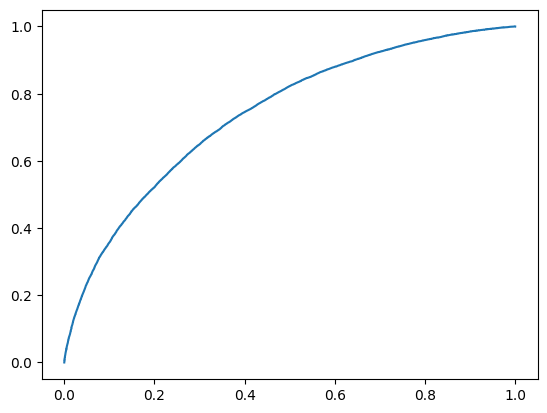

In [51]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test["target"], X_test["scores"])
plt.plot(fpr, tpr)

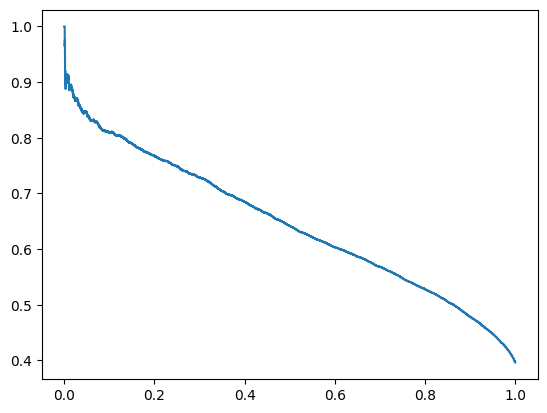

In [52]:
y, x, thr = precision_recall_curve(y_test["target"], X_test["scores"])
plt.plot(x, y)

<AxesSubplot:>

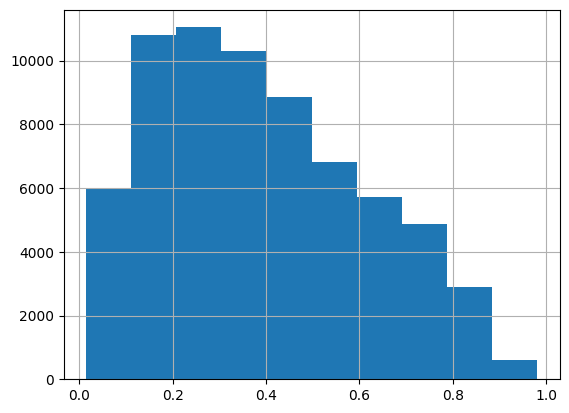

In [53]:
pd.Series(X_test["scores"]).hist()

<AxesSubplot:>

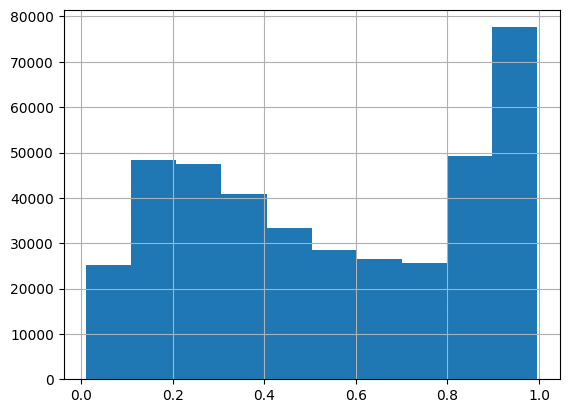

In [54]:
pd.Series(X_train["scores"]).hist()

<AxesSubplot:>

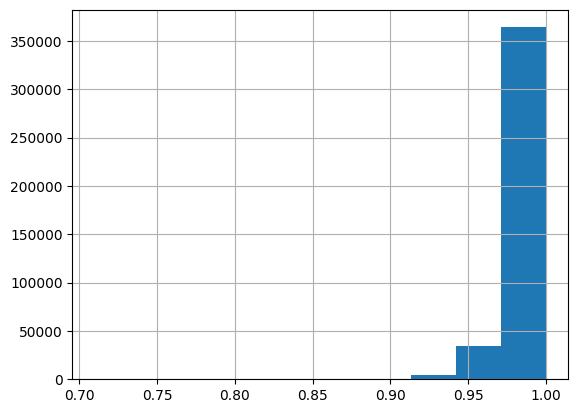

In [55]:
X_train.cos_sim.hist()

In [ ]:
X_train = X_train.merge(
    data[["target", "variantid1", "variantid2"]], right_index=True, left_index=True
)
X_test = X_test.merge(data[["target"]], right_index=True, left_index=True)

In [ ]:
pd.set_option("display.max_rows", 100)

# Submission

In [3]:
# test_pairs = pd.read_parquet("../datasets/test_pairs_wo_target.parquet")
test_pairs = pd.read_csv("../../files/datasets/test_for_participants.csv")
test_etl = pd.read_parquet("../../files/datasets/test_data.parquet")

In [7]:
goods_data
goods_data["cat3"] = goods_data["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = goods_data["cat3"].value_counts().to_dict()
goods_data["cat3_grouped"] = goods_data["cat3"].apply(
    lambda x: x if cat3_counts[x] > 1000 else "rest"
)
test_etl["cat3"] = test_etl["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = test_etl["cat3"].value_counts().to_dict()
test_etl["cat3_grouped"] = test_etl["cat3"].apply(
    lambda x: x if cat3_counts[x] > 500 else "rest"
)

In [57]:
cat_embed_test = torch.load('./y_embed_test.pt').reshape(-1, 64)
cat_idx_test = torch.load('./y_idxs_test.pt')
cat_embed_test = {i: j  for i, j in zip(cat_idx_test, cat_embed_test)}
# goods_pairs = pd.read_parquet('files/datasets/train_pairs_w_target.parquet')

In [58]:
tr_test = test_etl.categories.apply(lambda x: eval(x))
trim_test = pd.DataFrame(tr_test.to_list()).rename(
    columns={str(i): f"cat_{i}" for i in range(1, 5)}
)
trim_test["cat_2_en"] = trim_test.cat_2.map(dikt_cat_2)
trim_test["cat_3_en"] = trim_test.cat_3.map(dikt_cat_3)
trim_test["cat_4_en"] = trim_test.cat_4.map(dikt_cat_4)
trim_test = trim_test.merge(
    st,
    left_on=["cat_2_en", "cat_3_en", "cat_4_en"],
    right_on=["cat_2", "cat_3", "cat_4"],
    how="left",
)
test_etl["cat_encoded"] = trim_test["encoder"]

In [59]:
embedding_columns = ["main_pic_embeddings_resnet_v1", "name_bert_64", "cat_embed"]
symm_goods_pairs_test = symm_pairs(test_pairs)
dataset_test = ContrastiveDataset(
    test_etl, symm_goods_pairs_test, cat_embed_test, embedding_columns, mode=False
)
test_dataloader = DataLoader(
    dataset_test, batch_size=128, shuffle=False, drop_last=False, num_workers=2
)

In [60]:
yt = next(iter(test_dataloader))

In [61]:
predict_labels = []
for i in tqdm(range(test_pairs.shape[0])):
    t, a = get_pred(i)
    predict_labels.append(a)

  0%|          | 0/18086 [00:00<?, ?it/s]

In [62]:
test_pairs['predict_labels'] = predict_labels

In [63]:
test_pairs

,variantid1,variantid2,predict_labels
0,372065731,372070671,False
1,528068358,533445916,False
2,480899084,480899989,False
3,384479474,488458602,True
4,658044199,663187587,True
...,...,...,...
18081,405934001,695957034,False
18082,692224892,692246989,False
18083,388824213,658486072,False
18084,479858327,480111601,False


In [64]:
def predict(model, dataloader):
    y_idxs = []
    y_embed = []
    model.eval()
    for orig, _, _, _, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed


y_idxs, y_embed = predict(model, test_dataloader)

  0%|          | 0/280 [00:00<?, ?it/s]

In [65]:
embed_test = pd.DataFrame({"variant": y_idxs, "embed": y_embed})
classif_test = test_pairs.merge(
    embed_test,
    left_on="variantid1",
    right_on="variant",
    how="left",
    suffixes=["", "_1"],
)
classif_test = classif_test.merge(
    embed_test,
    left_on="variantid2",
    right_on="variant",
    how="left",
    suffixes=["", "_2"],
)
classif_test.drop(["variant", "variant_2"], axis=1, inplace=True)

In [66]:
classif_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18086 entries, 0 to 18085
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   variantid1      18086 non-null  int64 
 1   variantid2      18086 non-null  int64 
 2   predict_labels  18086 non-null  bool  
 3   embed           18086 non-null  object
 4   embed_2         18086 non-null  object
dtypes: bool(1), int64(2), object(2)
memory usage: 724.1+ KB


In [67]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances


def get_pic_features(main_pic_embeddings_1, main_pic_embeddings_2):
    """Calculate distances percentiles for
    pairwise pic distances. Percentiles are useful
    when product has several pictures.
    """

    embed = list(
        np.abs(
            np.array(main_pic_embeddings_1)[None, ...]
            - np.array(main_pic_embeddings_2)[None, ...]
        )[0]
    )

    cos_sim = cosine_similarity(
        np.array(main_pic_embeddings_1)[None, ...],
        np.array(main_pic_embeddings_2)[None, ...],
    )[0][0]

    # pair_features = []
    # pair_features += np.percentile(dist_m, percentiles).tolist()

    return embed, cos_sim

In [68]:
classif_test[
    [
        "embed_dif",
        "cos_sim",
    ]
] = classif_test[
    ["embed", "embed_2"]
].apply(lambda x: pd.Series(get_pic_features(*x)), axis=1)

In [69]:
classif_test = classif_test.merge(
    test_etl[["variantid", "categories", "cat_encoded"]],
    left_on="variantid1",
    right_on="variantid",
    how="left",
    suffixes=["", "_1"],
)
classif_test = classif_test.merge(
    test_etl[["variantid", "cat_encoded"]],
    left_on="variantid2",
    right_on="variantid",
    how="left",
    suffixes=["", "_2"],
)
classif_test["cat3"] = classif_test["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = classif_test["cat3"].value_counts().to_dict()

In [70]:
classif_test["cat3_grouped"] = classif_test["cat3"].apply(
    lambda x: x if cat3_counts[x] > 1000 else "rest"
)

In [71]:
def get_cat_diff(x, y):
    if not np.isnan(x) and not np.isnan(y):
        return (len(nx.bidirectional_shortest_path(G, int(x), int(y))) - 1) // 2
    else:
        return 0

In [72]:
classif_test["cat_dif"] = classif_test[["cat_encoded", "cat_encoded_2"]].apply(
    lambda x: get_cat_diff(*x), axis=1
)

In [73]:
dikt_categories = {
    i: j
    for i, j in zip(
        sorted(classif_test.cat_encoded.unique()),
        range(1, classif_test.cat_encoded.nunique() + 1),
    )
}
classif_test["category"] = classif_test.cat_encoded.map(dikt_categories)
classif_test.category = np.where(
    classif_test.cat3_grouped == "rest", 0, classif_test.category
)
embeddings = pd.DataFrame(classif_test["embed_dif"].tolist())
data_test = pd.concat([classif_test, embeddings], axis=1)

In [74]:
data_test = data_test[
    ["variantid1", "variantid2", "cos_sim", "cat_dif", 'predict_labels', ] + list(embeddings.columns)#'category'
]  #'category'

In [75]:
data_test["target"] = model_cat.predict_proba(data_test.drop(['variantid1', 'variantid2'], axis = 1))[:, 1]

In [76]:
submit = data_test[["variantid1", "variantid2", "target"]]

In [79]:
submit.to_csv("submition_last_4.csv", index=False, sep=",")

In [266]:
# from IPython.display import FileLink

# FileLink(r"submition_last_2.csv")

/home/andreychuk/files/Ozon_marketplace/submition_last_2.csv

In [77]:
submit.iloc[10:20]

,variantid1,variantid2,target
10,493573460,587481441,0.827781
11,91502637,585047902,0.734426
12,185789629,696087195,0.201525
13,447312641,447313347,0.206116
14,555583230,599512145,0.890106
15,238737191,437149011,0.770285
16,228350734,228354704,0.884742
17,387690243,406348303,0.174161
18,204196658,208311490,0.515681
19,460594798,460760951,0.651304


In [267]:
submit.shape

(18086, 3)

<AxesSubplot:>

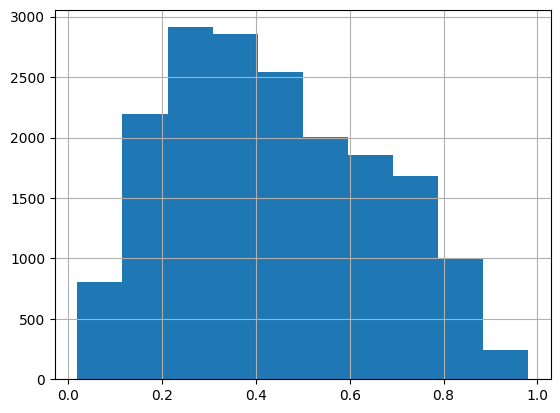

In [78]:
submit.target.hist()